In [1]:
%reload_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
import copy
import gc
import math
import random
from pathlib import Path
from PIL import Image
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

import cv2
from easydict import EasyDict
from tqdm.notebook import tqdm
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

import pytorch_lightning as pl

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
from transformers import (
    AdamW,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
)

<IPython.core.display.Javascript object>

# NIPA Round 1

In [48]:
args = dict(
    seed=42,
    num_plants=8,
    num_diseases=14,
    plant2idx={3: 0, 4: 1, 5: 2, 7: 3, 8: 4, 10: 5, 11: 6, 13: 7},
    disease2idx={
        1: 0,
        2: 1,
        5: 2,
        6: 3,
        7: 4,
        8: 5,
        9: 6,
        11: 7,
        14: 8,
        15: 9,
        16: 10,
        17: 11,
        18: 12,
        20: 13,
    },
    # Data
    model_path=Path("/home/isleof/Development/nipa/models"),
    data_path=Path("/home/isleof/Development/nipa/input/train"),
    data_path_128=Path("/home/isleof/Development/nipa/input/train-128"),
    test_data_path=Path("/home/isleof/Development/nipa/input/test"),
    train_csv=Path("/home/isleof/Development/nipa/input/train_folds.csv"),
    test_csv=Path("/home/isleof/Development/nipa/input/test.csv"),
    # Model
    backbone="gluon_seresnext50_32x4d",
    # Optimizer
    optimizer="adamw",
    lr=1e-3,
    weight_decay=1e-4,
    scheduler={"method": "cosine", "warmup_epochs": 1},
    # Train
    gradient_accumulation_steps=1,
    precision=16,
    num_workers=4,
    batch_size=64,
    max_epochs=40,
)

args["trn_aug"] = A.Compose(
    [
        A.OneOf(
            [
                A.IAAAdditiveGaussianNoise(p=1),
                A.GaussNoise(p=1),
            ],
            p=0.5,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(
                    brightness_limit=0.1, contrast_limit=0.1, p=1
                ),
                A.CLAHE(clip_limit=3, p=1),
                A.IAASharpen(p=1),
                A.IAAEmboss(p=1),
            ],
            p=0.5,
        ),
        A.OneOf(
            [
                A.MotionBlur(blur_limit=3, p=1),
                A.MedianBlur(blur_limit=3, p=1),
                A.GaussianBlur(p=1),
            ],
            p=0.5,
        ),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.5),
        A.Normalize(),
        ToTensorV2(),
    ]
)

args["val_aug"] = A.Compose([A.Normalize(), ToTensorV2()])

<IPython.core.display.Javascript object>

## Setup

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


seed_everything(args["seed"])

<IPython.core.display.Javascript object>

In [5]:
def visualize(dataset, idx=0):
    data = dataset[idx]
    img = data["img"]
    plant = data["plant"]
    disease = data["disease"]
    print(plant, disease)
    plt.imshow(img)
    plt.axis("off")


def visualize_tfms(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.tfms = A.Compose(
        [t for t in dataset.tfms if not isinstance(t, (A.Normalize, ToTensorV2))]
    )
    rows = samples // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        img = dataset[idx]["img"]
        ax.imshow(img)
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>

In [6]:
# df = pd.read_csv(
#     "../input/train.tsv", sep="\t", header=None, names=["img", "plant", "disease"]
# )

<IPython.core.display.Javascript object>

In [7]:
# test_df = pd.read_csv("../input/test.tsv", sep="\t", header=None, names=["img"])
# test_df.to_csv(args.test_csv, index=False)

<IPython.core.display.Javascript object>

In [8]:
df = pd.read_csv(args["train_csv"])
df.head()

,img,plant,disease,fold
0,13_16_475.jpg,13,16,0
1,3_5_936.jpg,3,5,3
2,13_15_126.jpg,13,15,2
3,4_11_605.jpg,4,11,1
4,3_20_1113.jpg,3,20,4


<IPython.core.display.Javascript object>

In [9]:
plants = list(sorted(df.plant.unique()))
diseases = list(sorted(df.disease.unique()))
print("Plant:", plants, len(plants))
print("Disease:", diseases, len(diseases))

Plant: [3, 4, 5, 7, 8, 10, 11, 13] 8
Disease: [1, 2, 5, 6, 7, 8, 9, 11, 14, 15, 16, 17, 18, 20] 14


<IPython.core.display.Javascript object>

## k-folds

In [7]:
df = df.sample(frac=1.0).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [8]:
df["fold"] = -1
y = df[["plant", "disease"]].values
kf = MultilabelStratifiedKFold(n_splits=5)
for fold, (trn_idx, val_idx) in enumerate(kf.split(df, y)):
    df.loc[val_idx, "fold"] = fold

<IPython.core.display.Javascript object>

In [9]:
df.to_csv(args["train_csv"], index=False)
df.head()

,img,plant,disease,fold
0,13_16_475.jpg,13,16,0
1,3_5_936.jpg,3,5,3
2,13_15_126.jpg,13,15,2
3,4_11_605.jpg,4,11,1
4,3_20_1113.jpg,3,20,4


<IPython.core.display.Javascript object>

## EDA

In [32]:
img_paths = list((args["data_path"]).iterdir())
img_paths[:5]

[PosixPath('/home/isleof/Development/nipa/input/train/13_17_1007.jpg'),
 PosixPath('/home/isleof/Development/nipa/input/train/4_7_830.jpg'),
 PosixPath('/home/isleof/Development/nipa/input/train/4_2_950.jpg'),
 PosixPath('/home/isleof/Development/nipa/input/train/3_20_1097.jpg'),
 PosixPath('/home/isleof/Development/nipa/input/train/8_6_616.jpg')]

<IPython.core.display.Javascript object>

(256, 256, 3)


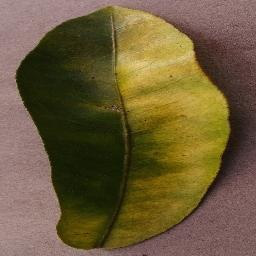

<IPython.core.display.Javascript object>

In [17]:
idx = np.random.randint(len(img_paths))
path = img_paths[idx]
img = Image.open(path).convert("RGB")
print(np.array(img).shape)
img

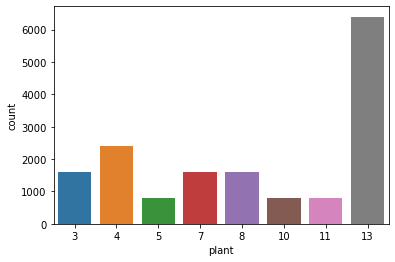

<IPython.core.display.Javascript object>

In [25]:
sns.countplot(df.plant)
plt.show()

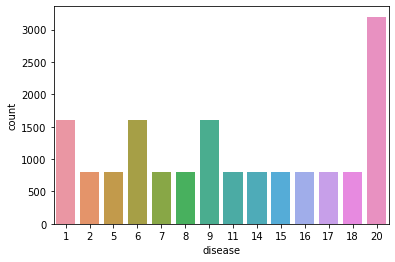

<IPython.core.display.Javascript object>

In [24]:
sns.countplot(df.disease)
plt.show()

## Resize

In [60]:
(PATH / "train-128").mkdir(exist_ok=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
def resize_img(fn):
    Image.open(fn).resize((128, 128)).save((fn.parent.parent) / "train-128" / fn.name)


with ThreadPoolExecutor(8) as e:
    e.map(resize_img, img_paths)

<IPython.core.display.Javascript object>

## Dataset

In [10]:
class PlantDataset(Dataset):
    def __init__(self, df, tfms=None, fast=True):
        self.imgs = df.img.values
        self.plants = [args["plant2idx"][plant] for plant in df.plant.values]
        self.diseases = [args["disease2idx"][disease] for disease in df.disease.values]
        self.tfms = tfms
        self.fast = fast

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        dir_path = args["data_path_128"] if self.fast else args["data_path"]
        img_path = dir_path / self.imgs[idx]
        plant = self.plants[idx]
        disease = self.diseases[idx]

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.tfms is not None:
            img = self.tfms(image=img)["image"]

        plant = torch.tensor(plant, dtype=torch.long)
        disease = torch.tensor(disease, dtype=torch.long)

        return {"img": img, "plant": plant, "disease": disease}

<IPython.core.display.Javascript object>

tensor(7) tensor(0)


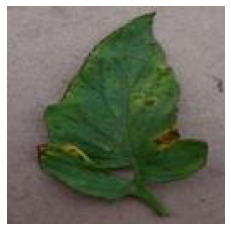

<IPython.core.display.Javascript object>

In [11]:
dataset = PlantDataset(df)
idx = np.random.randint(len(dataset))
visualize(dataset, idx)

## Transform

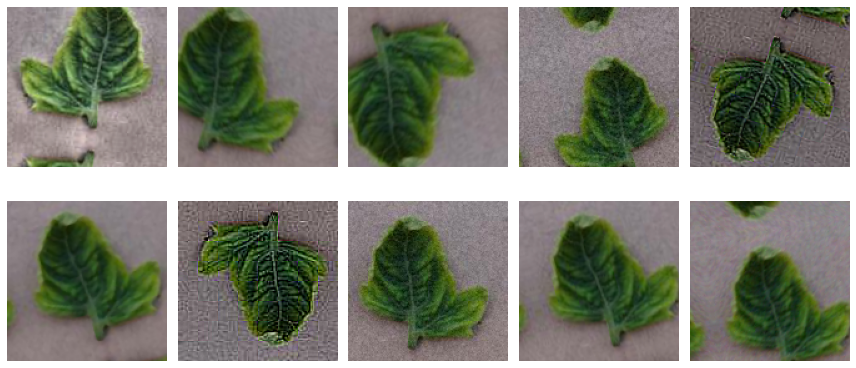

<IPython.core.display.Javascript object>

In [15]:
dataset = PlantDataset(df, tfms=args["trn_aug"])
idx = np.random.randint(len(dataset))
visualize_tfms(dataset, idx)

## Model

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    """
    NLL loss with label smoothing.
    """

    def __init__(self, smoothing=0.1):
        """
        Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothingCrossEntropy, self).__init__()
        assert smoothing < 1.0
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, x, target):
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()


class SoftTargetCrossEntropy(nn.Module):
    def __init__(self):
        super(SoftTargetCrossEntropy, self).__init__()

    def forward(self, x, target):
        loss = torch.sum(-target * F.log_softmax(x, dim=-1), dim=-1)
        return loss.mean()


class Backbone(nn.Module):
    def __init__(self, name="resnet18", pretrained=True):
        super().__init__()
        self.net = timm.create_model(name, pretrained=pretrained)

        if "regnet" in name:
            self.out_features = self.net.head.fc.in_features
        elif "csp" in name:
            self.out_features = self.net.head.fc.in_features
        elif "res" in name:  # works also for resnest
            self.out_features = self.net.fc.in_features
        elif "efficientnet" in name:
            self.out_features = self.net.classifier.in_features
        elif "densenet" in name:
            self.out_features = self.net.classifier.in_features
        elif "senet" in name:
            self.out_features = self.net.fc.in_features
        elif "inception" in name:
            self.out_features = self.net.last_linear.in_features
        else:
            self.out_features = self.net.classifier.in_features

    def forward(self, x):
        x = self.net.forward_features(x)

        return x


class Net(nn.Module):
    def __init__(self, args, pretrained=True):
        super().__init__()
        self.args = args
        self.backbone = Backbone(args["backbone"])
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.head1 = nn.Linear(self.backbone.out_features, args["num_plants"])
        self.head2 = nn.Linear(self.backbone.out_features, args["num_diseases"])

    def forward(self, x):
        x = self.backbone(x)

        x = self.global_pool(x)
        x = x[:, :, 0, 0]

        x1 = self.head1(x)
        x2 = self.head2(x)

        return {"plant": x1, "disease": x2}

In [45]:
class Model(pl.LightningModule):
    def __init__(self, trn_dl=None, val_dl=None):
        super().__init__()
        self.trn_dl = trn_dl
        self.val_dl = val_dl
        self.lr = args["lr"]
        if self.trn_dl is not None:
            self.num_train_steps = math.ceil(
                len(self.trn_dl) / args["gradient_accumulation_steps"]
            )

        self.model = Net(args)

        self.criterion = LabelSmoothingCrossEntropy()
        self.val_f1_plant = pl.metrics.Fbeta(num_classes=args["num_plants"], beta=1)
        self.val_f1_disease = pl.metrics.Fbeta(num_classes=args["num_diseases"], beta=1)

    def forward(self, x):
        return self.model(x)

    def shared_step(self, batch, batch_nb):
        img = batch["img"]
        plant = batch["plant"]
        disease = batch["disease"]

        output_dict = self(img)

        loss_plant = self.criterion(output_dict["plant"], plant)
        loss_disease = self.criterion(output_dict["disease"], disease)
        loss = 0.5 * loss_plant + 0.5 * loss_disease

        return loss, output_dict

    def training_step(self, batch, batch_nb):
        loss, _ = self.shared_step(batch, batch_nb)

        self.log("train_loss", loss)
        for i, param_group in enumerate(self.optimizer.param_groups):
            self.log(f"lr/lr{i}", param_group["lr"])

        return {"loss": loss}

    def validation_step(self, batch, batch_nb):
        target_plant = batch["plant"]
        target_disease = batch["disease"]
        loss, output_dict = self.shared_step(batch, batch_nb)

        logits_plant = output_dict["plant"]
        logits_disease = output_dict["disease"]

        self.val_f1_plant(logits_plant, target_plant)
        self.val_f1_disease(logits_disease, target_disease)

        return {"loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([o["loss"] for o in outputs]).mean()
        f1 = 0.5 * self.val_f1_plant.compute() + 0.5 * self.val_f1_disease.compute()
        self.val_f1_plant.reset()
        self.val_f1_disease.reset()
        self.log("val_f1", f1)
        print(f"Epoch: {self.current_epoch} | Loss: {avg_loss} | F1: {f1}")

    def configure_optimizers(self):
        self.optimizer = AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=args["weight_decay"]
        )
        self.scheduler = get_cosine_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=self.num_train_steps * args["scheduler"]["warmup_epochs"],
            num_training_steps=int(self.num_train_steps * args["max_epochs"]),
        )

        return [self.optimizer], [{"scheduler": self.scheduler, "interval": "step"}]

    def train_dataloader(self):
        return self.trn_dl

    def val_dataloader(self):
        return self.val_dl

<IPython.core.display.Javascript object>

## Train

In [ ]:
pl.seed_everything(args["seed"])

for fold in range(5):
    trn_df = df[df.fold != fold]
    val_df = df[df.fold == fold]

    trn_ds = PlantDataset(trn_df, tfms=args["trn_aug"], fast=False)
    val_ds = PlantDataset(val_df, tfms=args["val_aug"], fast=False)

    trn_dl = DataLoader(
        trn_ds,
        batch_size=args["batch_size"],
        sampler=RandomSampler(trn_ds),
        num_workers=args["num_workers"],
        pin_memory=True,
        drop_last=True,
    )
    val_dl = DataLoader(
        val_ds,
        batch_size=2 * args["batch_size"],
        sampler=SequentialSampler(val_ds),
        num_workers=args["num_workers"],
        pin_memory=True,
    )

    model = Model(trn_dl=trn_dl, val_dl=val_dl)
    #     early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    #         monitor="val_f1",
    #         verbose=True,
    #         mode="max"
    #     )
    trainer = pl.Trainer(
        gpus=1,
        auto_lr_find=True,
        benchmark=True,
        max_epochs=args["max_epochs"],
        precision=args["precision"],
        accumulate_grad_batches=args["gradient_accumulation_steps"],
        progress_bar_refresh_rate=50,
        #         callbacks=[early_stopping_callback]
    )
    trainer.fit(model)
    trainer.save_checkpoint(f"fold{fold}.ckpt")

    del model, trainer, trn_ds, val_ds, trn_dl, val_dl, trn_df, val_df
    gc.collect()
    torch.cuda.empty_cache()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name           | Type                       | Params
--------------------------------------------------------------
0 | model          | Net                        | 27 M  
1 | criterion      | LabelSmoothingCrossEntropy | 0     
2 | val_f1_plant   | Fbeta                      | 0     
3 | val_f1_disease | Fbeta                      | 0     


Epoch: 0 | Loss: 2.3750057220458984 | F1: 0.169921875


Epoch: 0 | Loss: 0.6909332871437073 | F1: 0.94140625


/home/isleof/.pyenv/versions/miniconda3-latest/envs/torch2/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Epoch: 1 | Loss: 0.5573702454566956 | F1: 0.9851562976837158


Epoch: 2 | Loss: 0.5511416792869568 | F1: 0.9879687428474426


Epoch: 3 | Loss: 0.6794592142105103 | F1: 0.9384374618530273


Epoch: 4 | Loss: 0.545320451259613 | F1: 0.9885937571525574


Epoch: 5 | Loss: 0.5339824557304382 | F1: 0.9921875


Epoch: 6 | Loss: 0.5369477868080139 | F1: 0.9901562333106995


Epoch: 7 | Loss: 0.5502638220787048 | F1: 0.9815624952316284


Epoch: 8 | Loss: 0.5574725866317749 | F1: 0.9792187213897705


Epoch: 9 | Loss: 0.5447843670845032 | F1: 0.9857812523841858


Epoch: 10 | Loss: 0.5358812212944031 | F1: 0.9887499809265137


Epoch: 11 | Loss: 0.5345543026924133 | F1: 0.9889062643051147


Epoch: 12 | Loss: 0.5303080081939697 | F1: 0.9915624856948853


Epoch: 13 | Loss: 0.5192864537239075 | F1: 0.9964061975479126


Epoch: 14 | Loss: 0.5248755812644958 | F1: 0.9937499761581421


Epoch: 15 | Loss: 0.5210753679275513 | F1: 0.9950000047683716


Epoch: 16 | Loss: 0.5181617736816406 | F1: 0.9964061975479126


Epoch: 17 | Loss: 0.5160101056098938 | F1: 0.9970312714576721


Epoch: 18 | Loss: 0.5228535532951355 | F1: 0.9945312738418579


Epoch: 19 | Loss: 0.5150541067123413 | F1: 0.9979687333106995


Epoch: 20 | Loss: 0.5210927724838257 | F1: 0.9937499761581421


Epoch: 21 | Loss: 0.5143381953239441 | F1: 0.9973437786102295


Epoch: 22 | Loss: 0.5111519694328308 | F1: 0.9985937476158142


Epoch: 23 | Loss: 0.5102740526199341 | F1: 0.9982812404632568


Epoch: 24 | Loss: 0.5119154453277588 | F1: 0.9984375238418579


Epoch: 25 | Loss: 0.5094277858734131 | F1: 0.9993749856948853


Epoch: 26 | Loss: 0.5102018117904663 | F1: 0.9993749856948853


Epoch: 27 | Loss: 0.5084225535392761 | F1: 0.9996874928474426


Epoch: 28 | Loss: 0.5092983245849609 | F1: 0.9993749856948853


Epoch: 29 | Loss: 0.5092548131942749 | F1: 0.9992187023162842


Epoch: 30 | Loss: 0.5088038444519043 | F1: 0.9995312690734863


Epoch: 31 | Loss: 0.5089561939239502 | F1: 0.9993749856948853


Epoch: 32 | Loss: 0.5081673860549927 | F1: 0.9995312690734863


Epoch: 33 | Loss: 0.5084618926048279 | F1: 0.9996874928474426


Epoch: 34 | Loss: 0.5080186128616333 | F1: 0.9998437166213989


Epoch: 35 | Loss: 0.5081988573074341 | F1: 0.9995312690734863


Epoch: 36 | Loss: 0.5082937479019165 | F1: 0.9995312690734863


Epoch: 37 | Loss: 0.5084507465362549 | F1: 0.9995312690734863


Epoch: 38 | Loss: 0.50818932056427 | F1: 0.9996874928474426


Epoch: 39 | Loss: 0.5082908272743225 | F1: 0.9995312690734863



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name           | Type                       | Params
--------------------------------------------------------------
0 | model          | Net                        | 27 M  
1 | criterion      | LabelSmoothingCrossEntropy | 0     
2 | val_f1_plant   | Fbeta                      | 0     
3 | val_f1_disease | Fbeta                      | 0     


Epoch: 0 | Loss: 2.410790205001831 | F1: 0.083984375


Epoch: 0 | Loss: 0.7295868992805481 | F1: 0.9246875047683716


/home/isleof/.pyenv/versions/miniconda3-latest/envs/torch2/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Epoch: 1 | Loss: 0.5715019702911377 | F1: 0.9831249713897705


Epoch: 2 | Loss: 0.5560572743415833 | F1: 0.9871875047683716


Epoch: 3 | Loss: 0.5733901262283325 | F1: 0.9785937070846558


Epoch: 4 | Loss: 0.5452851057052612 | F1: 0.9870312213897705


Epoch: 5 | Loss: 0.569011390209198 | F1: 0.9770312309265137


Epoch: 6 | Loss: 0.5545246601104736 | F1: 0.9823437929153442


Epoch: 7 | Loss: 0.5570502281188965 | F1: 0.9810937643051147


Epoch: 8 | Loss: 0.5302305221557617 | F1: 0.9929687976837158


Epoch: 9 | Loss: 0.5354317426681519 | F1: 0.9900000095367432


Epoch: 10 | Loss: 0.5254900455474854 | F1: 0.9934375286102295


Epoch: 11 | Loss: 0.5287216901779175 | F1: 0.9931250214576721


Epoch: 12 | Loss: 0.5379388928413391 | F1: 0.9889062643051147


Epoch: 13 | Loss: 0.5197174549102783 | F1: 0.99609375


Epoch: 14 | Loss: 0.5303794741630554 | F1: 0.9915624856948853


Epoch: 15 | Loss: 0.5246798396110535 | F1: 0.9954687356948853


Epoch: 16 | Loss: 0.5174863338470459 | F1: 0.9962499737739563


Epoch: 17 | Loss: 0.51911461353302 | F1: 0.9962500333786011


Epoch: 18 | Loss: 0.5167514681816101 | F1: 0.9968750476837158


Epoch: 19 | Loss: 0.523513913154602 | F1: 0.9942187070846558


Epoch: 20 | Loss: 0.5139699578285217 | F1: 0.9976562261581421


Epoch: 21 | Loss: 0.5135732293128967 | F1: 0.9981249570846558


Epoch: 22 | Loss: 0.512861967086792 | F1: 0.9981249570846558


Epoch: 23 | Loss: 0.515306830406189 | F1: 0.996874988079071


Epoch: 24 | Loss: 0.5133277773857117 | F1: 0.9973437786102295


Epoch: 25 | Loss: 0.5106033086776733 | F1: 0.9987499713897705


Epoch: 26 | Loss: 0.5109506249427795 | F1: 0.9985937476158142


Epoch: 27 | Loss: 0.5102516412734985 | F1: 0.9985937476158142


Epoch: 28 | Loss: 0.511080265045166 | F1: 0.9985937476158142


Epoch: 29 | Loss: 0.5102012753486633 | F1: 0.9987499713897705


Epoch: 30 | Loss: 0.5105524063110352 | F1: 0.9985937476158142


Epoch: 31 | Loss: 0.5101499557495117 | F1: 0.9985937476158142


Epoch: 32 | Loss: 0.5102219581604004 | F1: 0.9985937476158142


Epoch: 33 | Loss: 0.510044515132904 | F1: 0.9990625381469727


Epoch: 34 | Loss: 0.5099925994873047 | F1: 0.9990625381469727


Epoch: 35 | Loss: 0.5098149180412292 | F1: 0.9989062547683716


Epoch: 36 | Loss: 0.510047435760498 | F1: 0.9989062547683716


Epoch: 37 | Loss: 0.5098558664321899 | F1: 0.9992187023162842


Epoch: 38 | Loss: 0.5100114941596985 | F1: 0.9989062547683716


Epoch: 39 | Loss: 0.5099470019340515 | F1: 0.9990625381469727



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name           | Type                       | Params
--------------------------------------------------------------
0 | model          | Net                        | 27 M  
1 | criterion      | LabelSmoothingCrossEntropy | 0     
2 | val_f1_plant   | Fbeta                      | 0     
3 | val_f1_disease | Fbeta                      | 0     


Epoch: 0 | Loss: 2.42126727104187 | F1: 0.076171875


Epoch: 0 | Loss: 0.6592020988464355 | F1: 0.9520312547683716


/home/isleof/.pyenv/versions/miniconda3-latest/envs/torch2/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Epoch: 1 | Loss: 0.5553779602050781 | F1: 0.9862499833106995


Epoch: 2 | Loss: 0.5739398002624512 | F1: 0.9792187213897705


Epoch: 3 | Loss: 0.58011394739151 | F1: 0.9748437404632568


Epoch: 4 | Loss: 0.5665738582611084 | F1: 0.9798437356948853


Epoch: 5 | Loss: 0.5335742235183716 | F1: 0.9917187690734863


Epoch: 6 | Loss: 0.5732738375663757 | F1: 0.9792187213897705


Epoch: 7 | Loss: 0.5782451629638672 | F1: 0.9729687571525574


Epoch: 8 | Loss: 0.5286058187484741 | F1: 0.9929687976837158


Epoch: 9 | Loss: 0.5494704246520996 | F1: 0.9851562976837158


Epoch: 10 | Loss: 0.5349153280258179 | F1: 0.9923437833786011


Epoch: 11 | Loss: 0.53056800365448 | F1: 0.9914062023162842


Epoch: 12 | Loss: 0.524853527545929 | F1: 0.9945312738418579


Epoch: 13 | Loss: 0.51976478099823 | F1: 0.9965624809265137


Epoch: 14 | Loss: 0.5258294343948364 | F1: 0.9940624833106995


Epoch: 15 | Loss: 0.5288344621658325 | F1: 0.9917187690734863


Epoch: 16 | Loss: 0.5169010162353516 | F1: 0.996874988079071


Epoch: 17 | Loss: 0.5249798893928528 | F1: 0.9931250214576721


Epoch: 18 | Loss: 0.5150783061981201 | F1: 0.9976562261581421


Epoch: 19 | Loss: 0.5296339392662048 | F1: 0.9923437833786011


Epoch: 20 | Loss: 0.513418436050415 | F1: 0.9978125095367432


Epoch: 21 | Loss: 0.512761652469635 | F1: 0.9981249570846558


Epoch: 22 | Loss: 0.5118570327758789 | F1: 0.9982812404632568


Epoch: 23 | Loss: 0.5121703743934631 | F1: 0.9982812404632568


Epoch: 24 | Loss: 0.5118714570999146 | F1: 0.9982812404632568


Epoch: 25 | Loss: 0.5104350447654724 | F1: 0.9987499713897705


Epoch: 26 | Loss: 0.5103240013122559 | F1: 0.9989062547683716


Epoch: 27 | Loss: 0.5100846886634827 | F1: 0.9990625381469727


Epoch: 28 | Loss: 0.5099754333496094 | F1: 0.9990625381469727


Epoch: 29 | Loss: 0.5093216300010681 | F1: 0.9993749856948853


Epoch: 30 | Loss: 0.5098657608032227 | F1: 0.9987499713897705


Epoch: 31 | Loss: 0.5094290971755981 | F1: 0.9990625381469727


Epoch: 32 | Loss: 0.5088207721710205 | F1: 0.9995312690734863


Epoch: 33 | Loss: 0.5092132687568665 | F1: 0.9990625381469727


Epoch: 34 | Loss: 0.5093830227851868 | F1: 0.999218761920929


Epoch: 35 | Loss: 0.508903443813324 | F1: 0.9990625381469727


Epoch: 36 | Loss: 0.5087453126907349 | F1: 0.999218761920929


Epoch: 37 | Loss: 0.5089055299758911 | F1: 0.999218761920929


Epoch: 38 | Loss: 0.5088449120521545 | F1: 0.999218761920929


Epoch: 39 | Loss: 0.5088777542114258 | F1: 0.999218761920929



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name           | Type                       | Params
--------------------------------------------------------------
0 | model          | Net                        | 27 M  
1 | criterion      | LabelSmoothingCrossEntropy | 0     
2 | val_f1_plant   | Fbeta                      | 0     
3 | val_f1_disease | Fbeta                      | 0     


Epoch: 0 | Loss: 2.4096779823303223 | F1: 0.052734375


Epoch: 0 | Loss: 0.8333906531333923 | F1: 0.8782812356948853


/home/isleof/.pyenv/versions/miniconda3-latest/envs/torch2/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Epoch: 1 | Loss: 0.5885513424873352 | F1: 0.9715625047683716


Epoch: 2 | Loss: 0.5468631982803345 | F1: 0.9924999475479126


Epoch: 3 | Loss: 0.5587731003761292 | F1: 0.9801562428474426


Epoch: 4 | Loss: 0.5462145805358887 | F1: 0.9870312213897705


Epoch: 5 | Loss: 0.5291964411735535 | F1: 0.9939062595367432


Epoch: 6 | Loss: 0.5424284338951111 | F1: 0.989062488079071


Epoch: 7 | Loss: 0.5465959906578064 | F1: 0.9865624904632568


Epoch: 8 | Loss: 0.5396502614021301 | F1: 0.9901562333106995


Epoch: 9 | Loss: 0.5241423845291138 | F1: 0.9962500333786011


Epoch: 10 | Loss: 0.5194497108459473 | F1: 0.9962500333786011


Epoch: 11 | Loss: 0.5235949754714966 | F1: 0.9954687356948853


Epoch: 12 | Loss: 0.5213773250579834 | F1: 0.9959374666213989


Epoch: 13 | Loss: 0.5262376070022583 | F1: 0.9931249618530273


Epoch: 14 | Loss: 0.5183642506599426 | F1: 0.9975000023841858


Epoch: 15 | Loss: 0.5175317525863647 | F1: 0.9967187643051147


Epoch: 16 | Loss: 0.5273321270942688 | F1: 0.9934375286102295


Epoch: 17 | Loss: 0.5240784883499146 | F1: 0.9932812452316284


Epoch: 18 | Loss: 0.5118966102600098 | F1: 0.9987499713897705


Epoch: 19 | Loss: 0.5137131214141846 | F1: 0.9978125095367432


Epoch: 20 | Loss: 0.5134353637695312 | F1: 0.9981249570846558


Epoch: 21 | Loss: 0.5144361853599548 | F1: 0.9976562261581421


Epoch: 22 | Loss: 0.516011655330658 | F1: 0.9971874952316284


Epoch: 23 | Loss: 0.5107560753822327 | F1: 0.9989062547683716


Epoch: 24 | Loss: 0.5101327896118164 | F1: 0.9992187023162842


Epoch: 25 | Loss: 0.5103611350059509 | F1: 0.9987499713897705


Epoch: 26 | Loss: 0.5108177065849304 | F1: 0.9984375238418579


Epoch: 27 | Loss: 0.5103460550308228 | F1: 0.9989062547683716


Epoch: 28 | Loss: 0.5103898644447327 | F1: 0.9990625381469727


Epoch: 29 | Loss: 0.5086537599563599 | F1: 0.9998437166213989


Epoch: 30 | Loss: 0.5086936354637146 | F1: 0.9995312690734863


Epoch: 31 | Loss: 0.5087511539459229 | F1: 0.9995312690734863


Epoch: 32 | Loss: 0.508506715297699 | F1: 0.9996874928474426


Epoch: 33 | Loss: 0.5082719922065735 | F1: 0.9996874928474426


Epoch: 34 | Loss: 0.508415937423706 | F1: 0.9996874928474426


Epoch: 35 | Loss: 0.5083646178245544 | F1: 0.9996874928474426


Epoch: 36 | Loss: 0.5084325075149536 | F1: 0.9995312690734863


Epoch: 37 | Loss: 0.5082705020904541 | F1: 0.9996874928474426


Epoch: 38 | Loss: 0.5083425045013428 | F1: 0.9996874928474426


Epoch: 39 | Loss: 0.5081899762153625 | F1: 0.9996874928474426



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name           | Type                       | Params
--------------------------------------------------------------
0 | model          | Net                        | 27 M  
1 | criterion      | LabelSmoothingCrossEntropy | 0     
2 | val_f1_plant   | Fbeta                      | 0     
3 | val_f1_disease | Fbeta                      | 0     


Epoch: 0 | Loss: 2.4648795127868652 | F1: 0.06640625


Epoch: 0 | Loss: 0.8430900573730469 | F1: 0.8795312643051147


/home/isleof/.pyenv/versions/miniconda3-latest/envs/torch2/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Epoch: 1 | Loss: 0.598387598991394 | F1: 0.9692187309265137


Epoch: 2 | Loss: 0.5671482682228088 | F1: 0.9800000190734863


Epoch: 3 | Loss: 0.5549746751785278 | F1: 0.984375


Epoch: 4 | Loss: 0.5550324320793152 | F1: 0.9873437881469727


Epoch: 5 | Loss: 0.5857476592063904 | F1: 0.971250057220459


Epoch: 6 | Loss: 0.5831693410873413 | F1: 0.9753124713897705


Epoch: 7 | Loss: 0.5341824889183044 | F1: 0.9931249618530273


Epoch: 8 | Loss: 0.5323543548583984 | F1: 0.9909374713897705


Epoch: 9 | Loss: 0.5279529690742493 | F1: 0.991406261920929


Epoch: 10 | Loss: 0.534995973110199 | F1: 0.9931249618530273


Epoch: 11 | Loss: 0.5191662311553955 | F1: 0.9964061975479126


Epoch: 12 | Loss: 0.5368502736091614 | F1: 0.9926562309265137


Epoch: 13 | Loss: 0.5389763712882996 | F1: 0.9876562356948853


Epoch: 14 | Loss: 0.5214265584945679 | F1: 0.9948437213897705


Epoch: 15 | Loss: 0.5220060348510742 | F1: 0.9946874976158142


## Inference

In [24]:
class InferencePlantDataset(Dataset):
    def __init__(self, df, tfms=None):
        self.imgs = df.img.values
        self.tfms = tfms

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        dir_path = args["test_data_path"]
        img_path = dir_path / self.imgs[idx]

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.tfms is not None:
            img = self.tfms(image=img)["image"]

        return {"img": img}

<IPython.core.display.Javascript object>

In [26]:
test_df = pd.read_csv(args["test_csv"])
test_ds = InferencePlantDataset(test_df, tfms=args["val_aug"])
test_dl = DataLoader(
    test_ds,
    batch_size=2 * args["batch_size"],
    sampler=SequentialSampler(test_ds),
    num_workers=args["num_workers"],
    pin_memory=True,
)

<IPython.core.display.Javascript object>

In [38]:
idx2plants = {v: k for k, v in args["plant2idx"].items()}
idx2disease = {v: k for k, v in args["disease2idx"].items()}

<IPython.core.display.Javascript object>

In [49]:
fin_plants = np.zeros((len(test_df), args["num_plants"]))
fin_diseases = np.zeros((len(test_df), args["num_diseases"]))

for fold in tqdm(range(5)):
    model = Model.load_from_checkpoint(checkpoint_path=f"fold{fold}.ckpt")
    model.cuda()
    model.eval()

    plants = []
    diseases = []

    with torch.no_grad():
        for batch in test_dl:
            img = batch["img"]
            img = img.cuda()
            output_dict = model(img)
            plants.append(output_dict["plant"].detach().cpu().numpy())
            diseases.append(output_dict["disease"].detach().cpu().numpy())

    plants = np.concatenate(plants)
    diseases = np.concatenate(diseases)

    fin_plants += plants / 5
    fin_diseases += diseases / 5

    del model
    gc.collect()
    torch.cuda.empty_cache()

<IPython.core.display.Javascript object>

In [51]:
plants = fin_plants.argmax(-1)
diseases = fin_diseases.argmax(-1)

<IPython.core.display.Javascript object>

In [52]:
plants = [idx2plants[p] for p in plants]
diseases = [idx2disease[d] for d in diseases]

<IPython.core.display.Javascript object>

In [54]:
subm = test_df.copy()
subm["plant"] = plants
subm["disease"] = diseases
subm = subm[["img", "plant", "disease"]]
subm.head()

,img,plant,disease
0,0.jpg,3,5
1,1.jpg,3,20
2,2.jpg,4,2
3,3.jpg,4,7
4,4.jpg,4,11


<IPython.core.display.Javascript object>

In [55]:
subm.to_csv("submission.tsv", sep="\t", header=None, index=False)

<IPython.core.display.Javascript object>